In [1]:
#show_image function
from astropy import visualization as aviz
from astropy.nddata.blocks import block_reduce
from astropy.nddata.utils import Cutout2D
from matplotlib import pyplot as plt


def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriate stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

In [2]:
import os
#output appears below cells, don't need plt.show every time
%matplotlib inline
from pprint import pprint
import numpy as np
import astropy.io
from astropy.io import fits
import glob
from astropy.stats import mad_std
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc as ccdp
from pathlib import Path

Equations to note:
(noise is not removable)

$stars + noise = \frac{rawimage - bias - darkcurrent}{flat} - sky$

$darkcurrent + noise = \frac{darkframe - bias}{darkexposuretime}$

# Working with FITS files #

In [3]:
#working with a fits file
#open a fits file
#im = fits.open('./RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_30_secs_001.fits')
#get fits file info
#im.info()
#get fits file header, pprint prints in better format
#pprint(im[0].header)
#image data stored as a np array
#pprint(im[0].data)
#im.close()

In [4]:
#alternative way to read in fits files
ccd_im = CCDData.read('./RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_30_secs_001.fits', unit='adu')
pprint(ccd_im.header)
pprint(ccd_im.data)
del ccd_im

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4656 / length of data axis 1                          
NAXIS2  =                 3520 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'ZWO CCD ASI1600MM Pro' / CCD Name                                    
TELESCOP= 'SynScan '        

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [5]:
#reads in multiple images at once
im_collection = ccdp.ImageFileCollection('./RZ Cep/2023_1_23/RZ_Cep/Light/Blue/')

In [6]:
im_collection.summary

<Table masked=True length=112>
              file               ...
             str32               ...
-------------------------------- ...
star_Light_Blue_30_secs_001.fits ...
star_Light_Blue_30_secs_002.fits ...
star_Light_Blue_30_secs_003.fits ...
star_Light_Blue_30_secs_004.fits ...
star_Light_Blue_30_secs_005.fits ...
star_Light_Blue_30_secs_006.fits ...
star_Light_Blue_30_secs_007.fits ...
star_Light_Blue_30_secs_008.fits ...
star_Light_Blue_30_secs_009.fits ...
star_Light_Blue_30_secs_010.fits ...
                             ... ...
star_Light_Blue_45_secs_026.fits ...
star_Light_Blue_45_secs_027.fits ...
star_Light_Blue_45_secs_028.fits ...
star_Light_Blue_45_secs_029.fits ...
star_Light_Blue_45_secs_030.fits ...
star_Light_Blue_45_secs_031.fits ...
star_Light_Blue_45_secs_032.fits ...
star_Light_Blue_45_secs_033.fits ...
star_Light_Blue_45_secs_034.fits ...
star_Light_Blue_45_secs_035.fits ...

In [7]:
#iterates over a select exposure time in the image set
#for image in im_collection.hdus(exptime=45.0, save_with_name=False, save_location=False, overwrite=True):
    #prints the altitude of the object associated with only the images with this exposure time
    #print(image.header['OBJCTALT'])
    
#im_collection.files_filtered(exptime=45.0)
im_collection_filt = im_collection.files_filtered(exptime=45.0, include_path=True)
im_collection_filt

['./RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_001.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_002.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_003.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_004.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_005.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_006.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_007.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_008.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_009.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_010.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_011.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_012.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue/star_Light_Blue_45_secs_013.fits',
 './RZ Cep/2023_1_23/RZ_Cep/Light/Blue

# Bias frames #

No overscan noted on our images, so no calibration is needed. 

In [8]:
#create a master bias
bias_ims = ccdp.ImageFileCollection('./RZ Cep/2023_1_23/Bias/')
#filters our only bias frames
bias_set = bias_ims.files_filtered(imagetyp='Bias Frame', include_path=True)
#sigma clippping clips pixels with values higher or lower than a certain standard deviation from the median. 
#99.7% of data is within 3std assuming a Gaussian, and one std = ~1.5mad
bias_master = ccdp.combine(bias_set, method='median', sigma_clip=True, sigma_clip_low_thresh=4, sigma_clip_high_thresh=4, 
                           sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu')
bias_master.meta['Combined'] = True

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


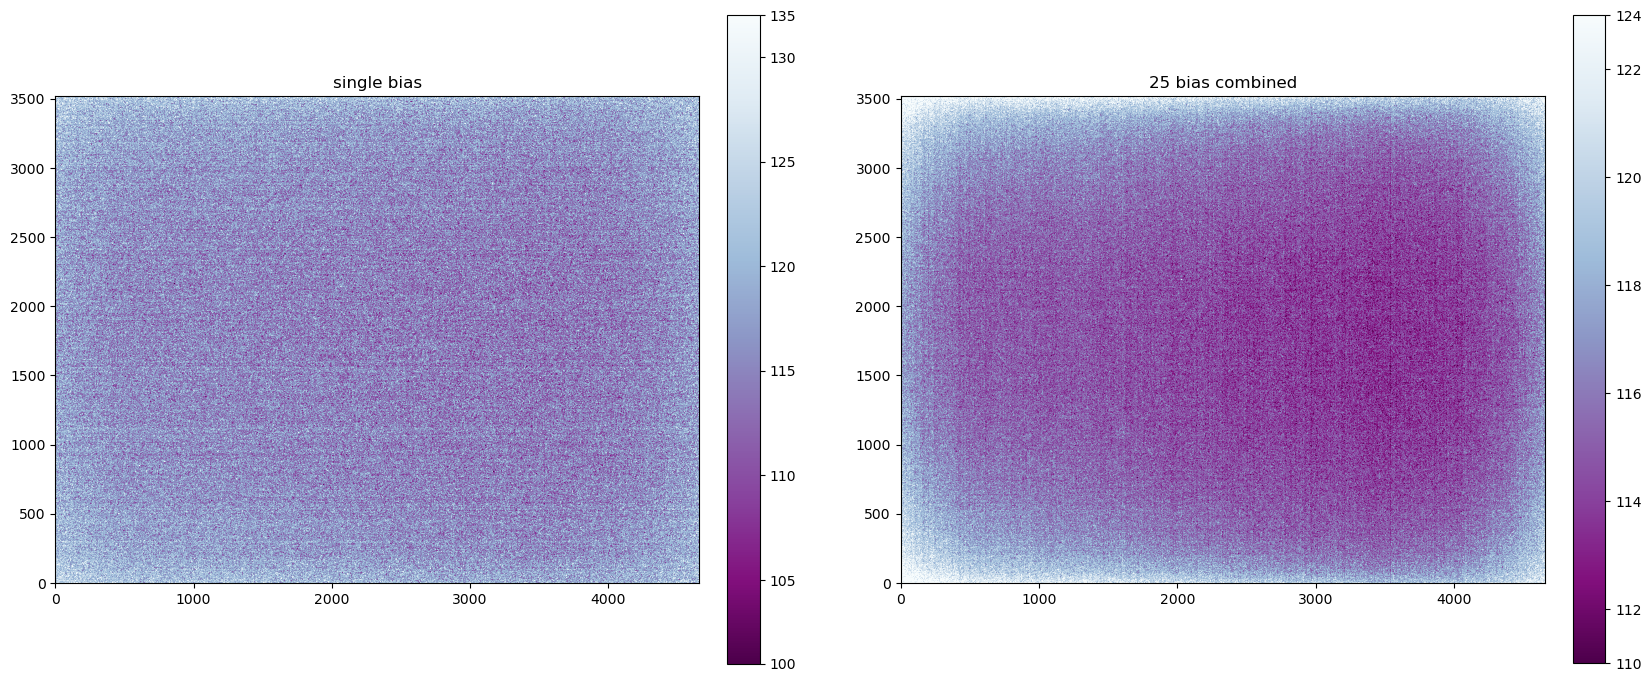

In [9]:
#plot the biases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#note (to do with show_image):
#percl is lower percentile for astronomical stretch. percl is lower percentile edge, so if percl = 90 then 
#the bottom ten percent is streched to fill 90% of the image, with the upper 90% being squashed into the remaining
#upper 10%
show_image(CCDData.read(bias_set[0], unit='adu').data, cmap='BuPu_r', ax=ax1, fig=fig)
ax1.set_title('single bias')
show_image(bias_master.data, cmap='BuPu_r', ax=ax2, fig=fig)
ax2.set_title('25 bias combined')

#save master bias
bias_master.write('./RZ Cep/2023_1_23/Bias/Bias_0.000032_secs_master.fits', overwrite=True)

# Dark frames and dark current #

- Dark frames contain counts of photons, which are detected by conversion of photons into electronic signals. The dark electrons in an exposure (per pixel) DE(t) is DC(T) x t where DC is dark current (temperature dependent) and t is time. 
- Dark counts is DE(t)/g where g is gain. 
- Dark current, in the ideal case, follows a Poisson distribution.
- Our gain is 139, meaning 1 electron per ADU. 
- With a high noise, combining images will not recover the full dark current. The dark frames instead measure noise. Combining images with a lower noise can recover the Poission distribution of expected dark current to a higher degree.
- Dark frames are ideally taken with a greater exposure time, so expected dark current counts match or exceed counts due to noise.
- Noise in a combined image is proportional to 1/sqrt(number of images combined)
- Min exposure time is read noise/expected dark current
- Hot pixel - pixels with significantly higher dark current than the rest, can mask them out above some threshold value
- If the dark frames do not need to be scaled to the correct exposure time, then the bias doesn't need to be included in analysis as the dark frame also serves to remove the bias. If it does need to be scaled then the bias must be subtracted from the dark frame.

In [10]:
#scale dark frames to match light frame exposure time
#read in dark frames
dark_ims = ccdp.ImageFileCollection('./RZ Cep/2023_1_23/Dark/')
#dark_set.summary
#exposure time for all dark frames is 45 seconds
#light frames have exposure time of 10 or 15 seconds

In [11]:
#filter through dark frames to check they are all in fact dark frames
dark_set = dark_ims.files_filtered(imagetyp='Dark Frame', include_path=True)
#print(len(dark_set))

#create a master dark frame using same method from bias master
dark_master = ccdp.combine(dark_set, method='median', sigma_clip=True, sigma_clip_low_thresh=4, sigma_clip_high_thresh=4, 
                           sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu') 
dark_master.meta['Combined'] = True

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


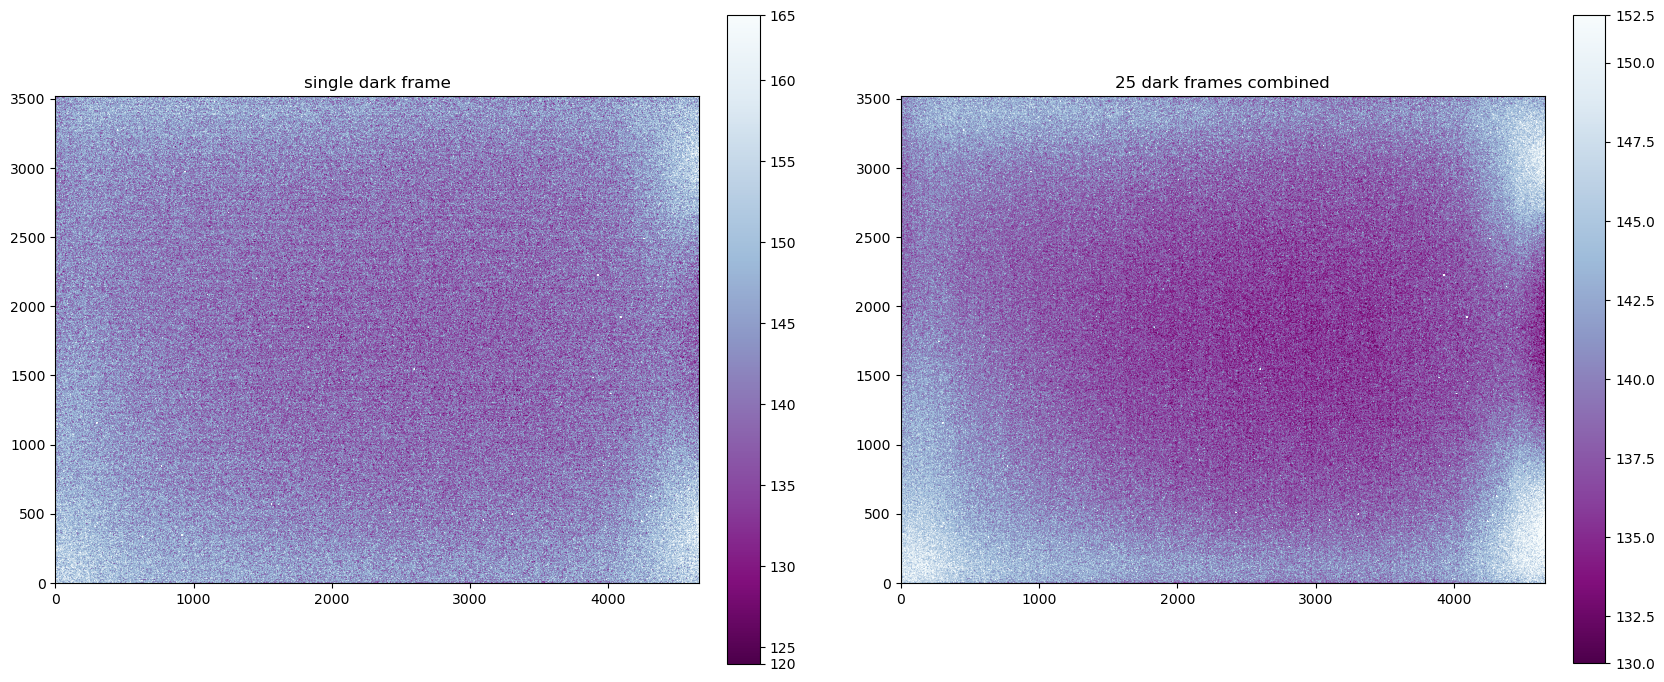

In [12]:
#plot the dark frames
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(dark_set[0], unit='adu').data, cmap='BuPu_r', ax=ax1, fig=fig)
ax1.set_title('single dark frame')
show_image(dark_master.data, cmap='BuPu_r', ax=ax2, fig=fig)
ax2.set_title('25 dark frames combined')

#save master dark
dark_master.write('./RZ Cep/2023_1_23/Dark/Dark_45_secs_master.fits', overwrite=True)

Text(0.5, 1.0, 'Master Dark Frame with Bias Subtracted')

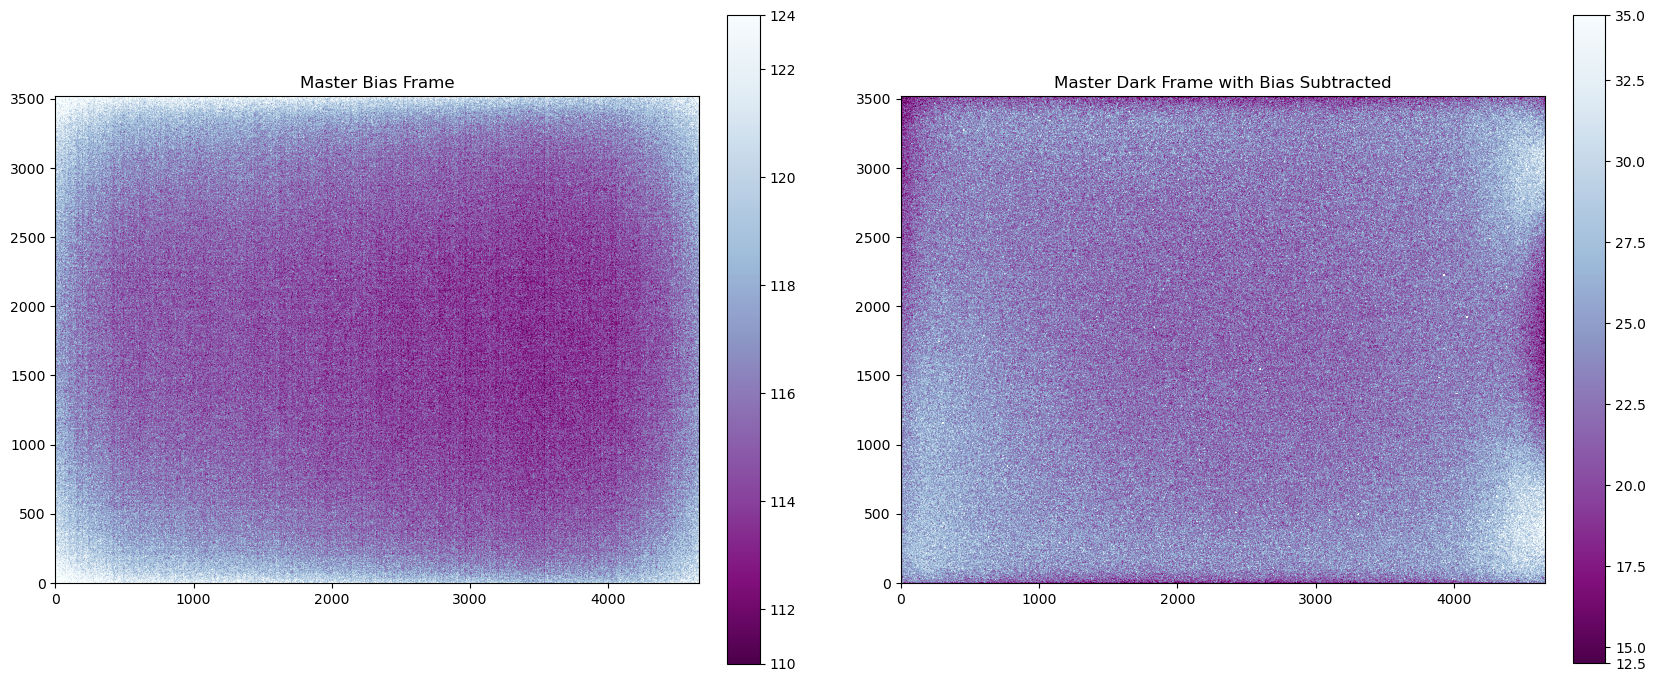

In [13]:
#take master bias away from master dark 
dark_bias_subtracted = ccdp.subtract_bias(dark_master, bias_master)
dark_bias_subtracted.write('./RZ Cep/2023_1_23/Dark/Dark_45_secs_Bias_Subtracted.fits', overwrite=True)

#show master bias and master dark with bias removed. can only perform this step of dark - bias if dark does not need
#to be scaled with exposure time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(bias_master.data, cmap='BuPu_r', ax=ax1, fig=fig)
ax1.set_title('Master Bias Frame')
show_image(dark_bias_subtracted.data, cmap='BuPu_r', ax=ax2, fig=fig)
ax2.set_title('Master Dark Frame with Bias Subtracted')

# Flat frames #

- Will need to be normalised to a common median or mean, as images taken when the sky is slightly brighter will unfairly dominate the master flat frame

In [14]:
#read in a flat frame as a CCDData object and display it
#flat = CCDData.read('./RZ Cep/2023_1_23/Flat/Luminance/Flat_Luminance_6_secs_001.fits', unit='adu')
#show_image(flat, cmap='BuPu_r')

In [15]:
#flat frames have exposure time of 6 seconds, whereas dark frames have exposure time of 45 seconds.
#therefore, we must subtract the bias frame first individually
#flat_bias_subtracted = ccdp.subtract_bias(flat, bias_master)

#show bias subtracted flat frame
#show_image(flat_bias_subtracted, cmap='BuPu_r')
#plt.title('Single flat frame, bias subtracted')

In [16]:
#set up exposure times with correct units, as subtract_dark requires an astropy Quantity object
dark_exp_unit = 45. * u.second
data_exp_unit = 6. * u.second

#subtract dark frame, scaling with exposure time
#flat_bias_dark_subtracted = ccdp.subtract_dark(flat_bias_subtracted, dark_master, dark_exposure=dark_exp_unit, 
#                                               data_exposure=data_exp_unit, exposure_unit=u.second, scale=True)

#show bias and dark reduced flat frame
#show_image(flat_bias_dark_subtracted, cmap='BuPu_r')
#plt.title('Single flat frame, bias and scaled dark subtracted')

In [17]:
#do for every individual flat frame, as they must be scaled to a common median before combination
for i in range(1, 25):
    flate = CCDData.read(f'./RZ Cep/2023_1_23/Flat/Luminance/Flat_Luminance_6_secs_{i:03}.fits', unit="adu")
    flate_subtracted = ccdp.subtract_bias(flate, bias_master)
    flate_subtracted = ccdp.subtract_dark(flate_subtracted, dark_master, dark_exposure=dark_exp_unit, 
                                          data_exposure=data_exp_unit, exposure_unit=u.second, scale=True)
    flate_subtracted.meta['SCALED'] = True
    flate_subtracted.write(f'./RZ Cep/2023_1_23/Flat/Luminance Reduced/Flat_Luminance_6_secs_{i:03}_reduced.fits', 
                           overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


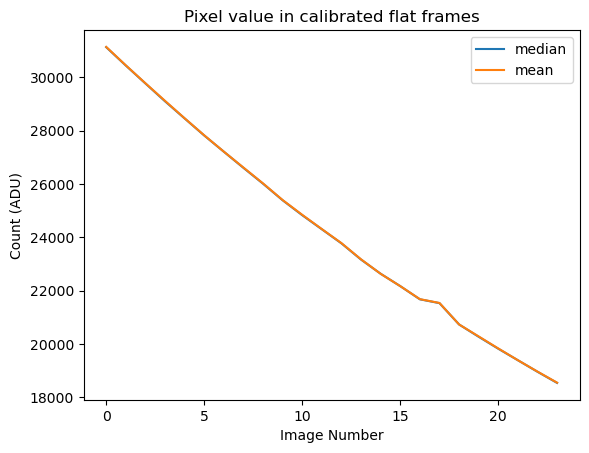

In [18]:
#read in calibrated flat fields as new files
flat_cal_lum = ccdp.ImageFileCollection('./RZ Cep/2023_1_23/Flat/Luminance Reduced/')
#check mean and median counts for each of these flat frames
#median_count = [np.median(np.asarray(data)) for np.asarray(data) in flat_cal_lum.ccds()]
#mean_count = [np.mean(data) for data in flat_cal_lum.data()]

median_count = []
mean_count = []

for i in range(1, 25):
    flate_cal = CCDData.read(f'./RZ Cep/2023_1_23/Flat/Luminance Reduced/Flat_Luminance_6_secs_{i:03}_reduced.fits', unit="adu")
    median = np.median(flate_cal.data)
    mean = np.mean(flate_cal.data)
    median_count.append(median)
    mean_count.append(mean)

#plot to show differences
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image Number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
plt.show()

In [19]:
#median and mean are virtually identical, but median is better to use so extreme values have less effect
#to scale data, use an inverse median function
def inverse_median(x):
    return 1/np.median(x)

#check all use the same filter
flat_cal_lum_filt = flat_cal_lum.files_filtered(imagetyp='Flat Frame', filter='Luminance', include_path=True)
#combine flats with sigma clipping
flat_master = ccdp.combine(flat_cal_lum_filt, method='median', scale=inverse_median, sigma_clip=True, 
                           sigma_clip_low_thresh=4, sigma_clip_high_thresh=4, sigma_clip_func=np.ma.median,
                           sigma_clip_dev_func=mad_std)
flat_master.meta['Combined'] = True
#save as a new file
flat_master.write('./RZ Cep/2023_1_23/Flat/Luminance Reduced/Flat_Luminance_6_secs_master.fits', overwrite=True)

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]


# Reducing light frames #

In [20]:
#read in some light frames (MUST BE SAME KIND AS MASTER FLAT FRAME!!!!!!)
#set the current file we are looking at
current_file = "Luminance"

#set the path to the current file we are looking at
current_path = f'./RZ Cep/2023_1_23/RZ_Cep/Light/{current_file}/'

#create a list of files in the directory (file) indicated by the path, just in case some sub folders exist or files that are
#not of the FITS type. Exclude a corrupted file.
file_list = [f for f in os.listdir(current_path) if f.endswith(".fits") and f != 'star_Light_Luminance_10_secs_051.fits']

#convert the
raw_path = Path(current_path)

#read in the images
raw_ims = ccdp.ImageFileCollection(raw_path, filenames=file_list)

In [22]:
#reduce the light frame

#define path for new reduced files to be written to
file_path = Path(f'./RZ Cep/2023_1_23/RZ_Cep/Light/{current_file} Reduced')

#filter all exposure times of 10 secs, as some are 15 secs long so will require slightly different analysis
#iterate over image data and file name in the set of files
for light, file_name in raw_ims.ccds(imagetyp='Light Frame', ccd_kwargs={'unit':'adu'}, return_fname=True):
    #read in file header
    header_info = CCDData.read(raw_path / file_name, unit='adu').header
    #save exposure time
    exptime = header_info['exptime']
    #delete the read in file to save memory
    del header_info
    #make a new file name to be associated with the reduced image
    file_name = file_name.replace('.fits', '_reduced.fits')
    print(f"exptime={exptime}")
    #convert image data into the correct data type
    light = CCDData(light, unit="adu")
    
    #filter the operations done on the raw data by exposure time
    if exptime == 45:
        #subtract the master dark, which also serves to remove the bias
        reduced = ccdp.subtract_dark(reduced, dark_master, scale=False)
        
    else:
        #subtract the master bias
        reduced = ccdp.subtract_bias(light, bias_master)

        #scale and subtract the dark with bias removed so it's not subtracted twice
        reduced = ccdp.subtract_dark(reduced, dark_bias_subtracted, dark_exposure=dark_exp_unit, data_exposure=exptime * u.second, 
                                 exposure_unit=u.second, scale=True)
    
    #subtract the master flat
    reduced = ccdp.flat_correct(reduced, flat_master)
    #print the new file name to check it worked correctly
    print(file_name)
    
    #update header/meta of new light file to include it has been reduced
    reduced.meta['REDUCED'] = True
    #write to new file
    reduced.write(file_path / file_name, overwrite=True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_001_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_002_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_003_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_004_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_005_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_006_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_007_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_008_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_009_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_010_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_011_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_012_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_013_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_014_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_015_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_016_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_017_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_018_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_019_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_020_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_021_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_022_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_023_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_024_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_025_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_026_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_027_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_028_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_029_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_030_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_031_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_032_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_033_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_034_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_035_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_036_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_037_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_038_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_039_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_040_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_041_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_042_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_043_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_044_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_045_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_046_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_047_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_048_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_049_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_050_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_052_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_053_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_054_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_055_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_056_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_057_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_058_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_059_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_060_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_061_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_062_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_063_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_064_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_065_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_066_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_067_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_068_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_069_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_070_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_071_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_072_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_073_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_074_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_075_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_076_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_077_reduced.fits


exptime=10.0
star_Light_Luminance_10_secs_078_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_001_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_002_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_003_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_004_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_005_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_006_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_007_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_008_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_009_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_010_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_011_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_012_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_013_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_014_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_015_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_016_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_017_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_018_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_019_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_020_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_021_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_022_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_023_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_024_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_025_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_026_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_027_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_028_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_029_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_030_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_031_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_032_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_033_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_034_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_035_reduced.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=15.0
star_Light_Luminance_15_secs_036_reduced.fits


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Text(0.5, 1.0, 'Light Frame with Master Bias, Dark Current and Flat Frames Subtracted')

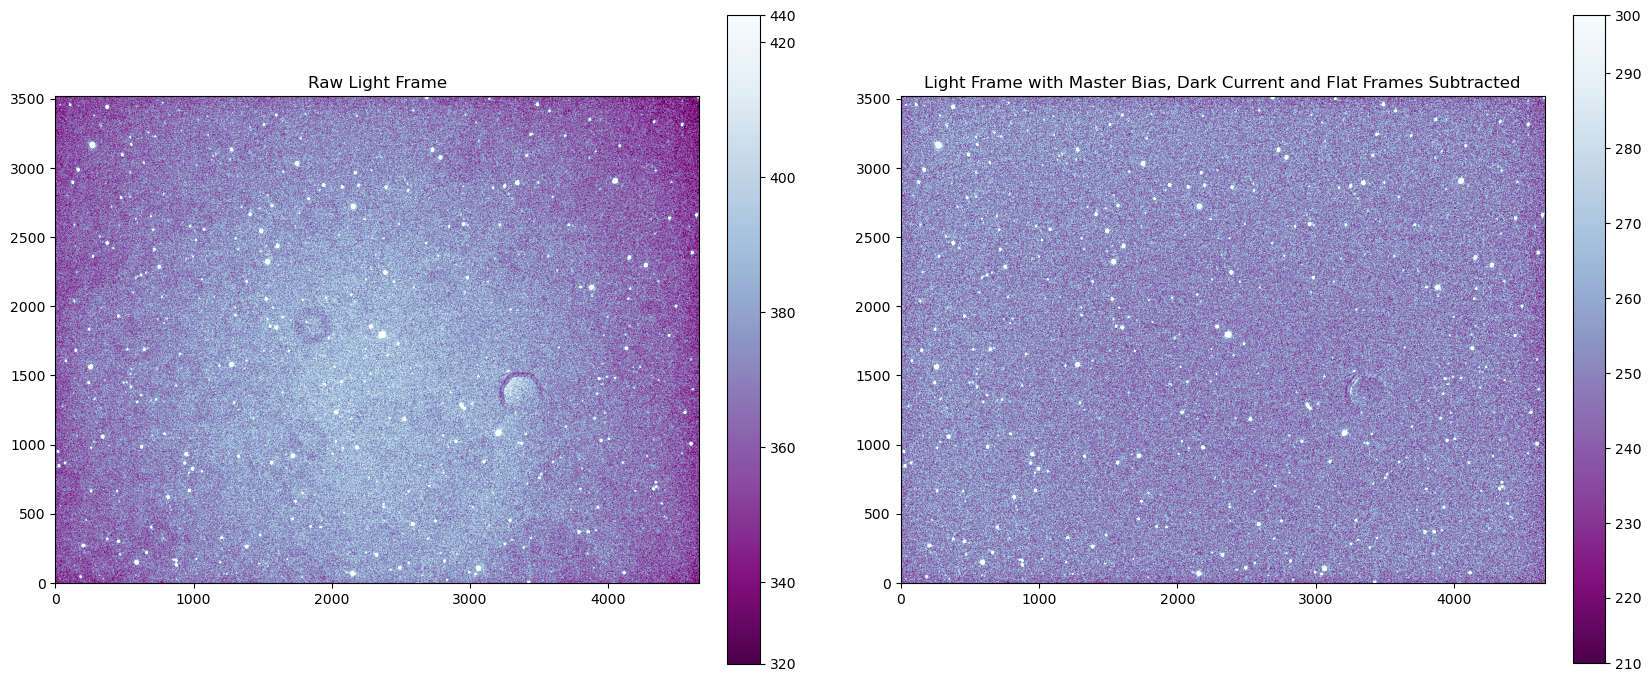

In [7]:
#read in reduced file and its associated raw file
lum_ccd = CCDData.read('./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/Lights/Luminance/star_Light_Luminance_5_secs_001.fits', unit='adu')
reduced_lum = CCDData.read('./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/Lights/Luminance Reduced/star_Light_Luminance_5_secs_001_reduced.fits', unit='adu')

#plot example raw and reduced light frames to show the data reduction works
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(lum_ccd.data, cmap='BuPu_r', ax=ax1, fig=fig)
ax1.set_title('Raw Light Frame')
show_image(reduced_lum.data, cmap='BuPu_r', ax=ax2, fig=fig)
ax2.set_title('Light Frame with Master Bias, Dark Current and Flat Frames Subtracted')

In [24]:
#tests that header wrote to file and updated correctly
reduced_lum.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4656                                                  
NAXIS2  =                 3520                                                  
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'ZWO CCD ASI1600MM Pro' / CCD Name                                    
TELESCOP= 'SynScan '           / Telescope name                                 
OBSERVER= 'Unknown '           / Observer name                                  
OBJECT  = 'star    '        